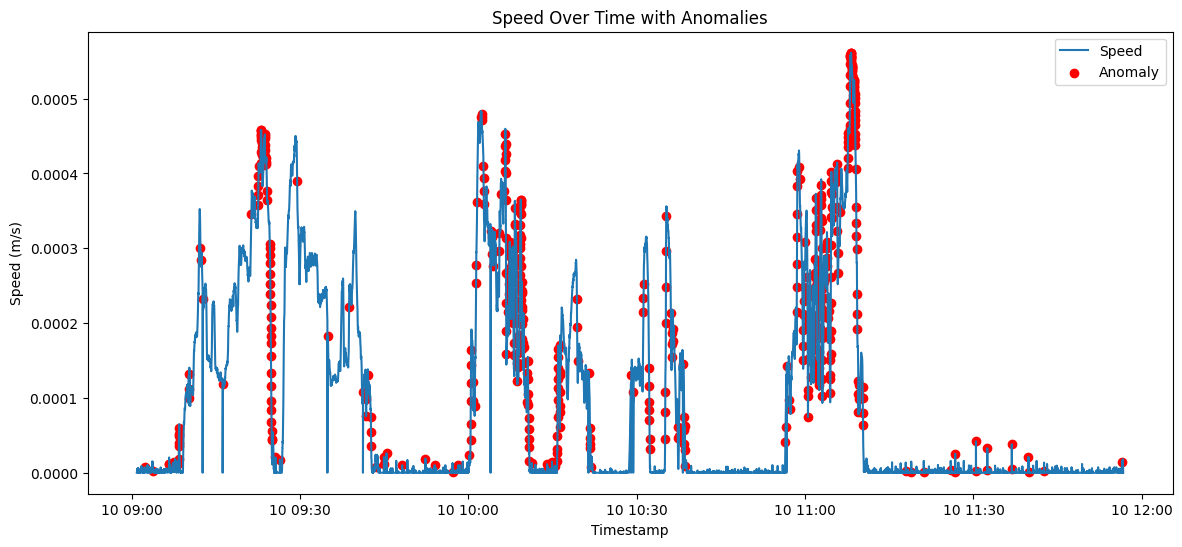

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pandas as pd

# Load the nmea.csv file
data = pd.read_csv('nmea.csv')

# Strip spaces from column names
data.columns = data.columns.str.strip()

# Convert 'timestamp' to datetime if it exists
if 'timestamp' in data.columns:
    data['timestamp'] = pd.to_datetime(data['timestamp'])

# Define latitude and longitude column names
lat_column = 'lat'
lon_column = 'lon'

# Check if 'speed' exists; calculate if missing and latitude/longitude are available
if 'speed' not in data.columns:
    if lat_column in data.columns and lon_column in data.columns:
        # Calculate speed from lat/lon differences and timestamp if columns are available
        data['speed'] = np.sqrt(data[lat_column].diff()**2 + data[lon_column].diff()**2) / data['timestamp'].diff().dt.total_seconds().fillna(1)
    else:
        print("No latitude/longitude or speed column found. Please add these columns to proceed.")
        data['speed'] = np.nan  # Placeholder

# Calculate speed difference if missing
if 'speed' in data.columns:
    data['speed_diff'] = data['speed'].diff().fillna(0)
else:
    data['speed_diff'] = 0  # Placeholder if speed is unavailable

# Calculate time difference
data['time_diff'] = data['timestamp'].diff().dt.total_seconds().fillna(1)

# Check if latitude/longitude are available for direction calculation
if lat_column in data.columns and lon_column in data.columns:
    data['direction_change'] = np.arctan2(data[lat_column].diff(), data[lon_column].diff()).fillna(0)
else:
    data['direction_change'] = 0  # Placeholder if direction calculation is not possible

# Replace any infinities or NaNs in the features
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

# Select features for anomaly detection
features = data[['speed', 'speed_diff', 'time_diff', 'direction_change']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly'] = isolation_forest.fit_predict(features_scaled)

# Convert -1 (anomaly) to True and 1 (normal) to False
data['anomaly'] = data['anomaly'] == -1

# Plot anomalies
plt.figure(figsize=(14, 6))
plt.plot(data['timestamp'], data['speed'], label="Speed")
plt.scatter(data['timestamp'][data['anomaly']], data['speed'][data['anomaly']], color='red', label="Anomaly")
plt.title("Speed Over Time with Anomalies")
plt.xlabel("Timestamp")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.show()


In [2]:
# Define window size for the LSTM input sequences
window_size = 10  # This can be adjusted based on data patterns

# Create sequences and labels for LSTM
X, y = [], []
for i in range(len(features_scaled) - window_size):
    X.append(features_scaled[i:i + window_size])
    y.append(data['anomaly'].iloc[i + window_size])

X, y = np.array(X), np.array(y)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))


In [3]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model with an explicit Input layer
model = Sequential()
model.add(Input(shape=(window_size, X.shape[2])))  # Define input shape here
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=10, batch_size=16, validation_split=0.3)


Epoch 1/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9212 - loss: 0.3616 - val_accuracy: 0.9592 - val_loss: 0.1035
Epoch 2/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9521 - loss: 0.1461 - val_accuracy: 0.9760 - val_loss: 0.0841
Epoch 3/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9514 - loss: 0.1469 - val_accuracy: 0.9624 - val_loss: 0.0880
Epoch 4/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9590 - loss: 0.1181 - val_accuracy: 0.9687 - val_loss: 0.0888
Epoch 5/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9554 - loss: 0.1191 - val_accuracy: 0.9734 - val_loss: 0.0812
Epoch 6/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9604 - loss: 0.1108 - val_accuracy: 0.9627 - val_loss: 0.0943
Epoch 7/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9651 - loss: 0.0994 - val_accuracy: 0.9649 - val_loss: 0.0854
Epoch 8/10
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9617 - loss: 0.1070 - val_accuracy: 0.

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


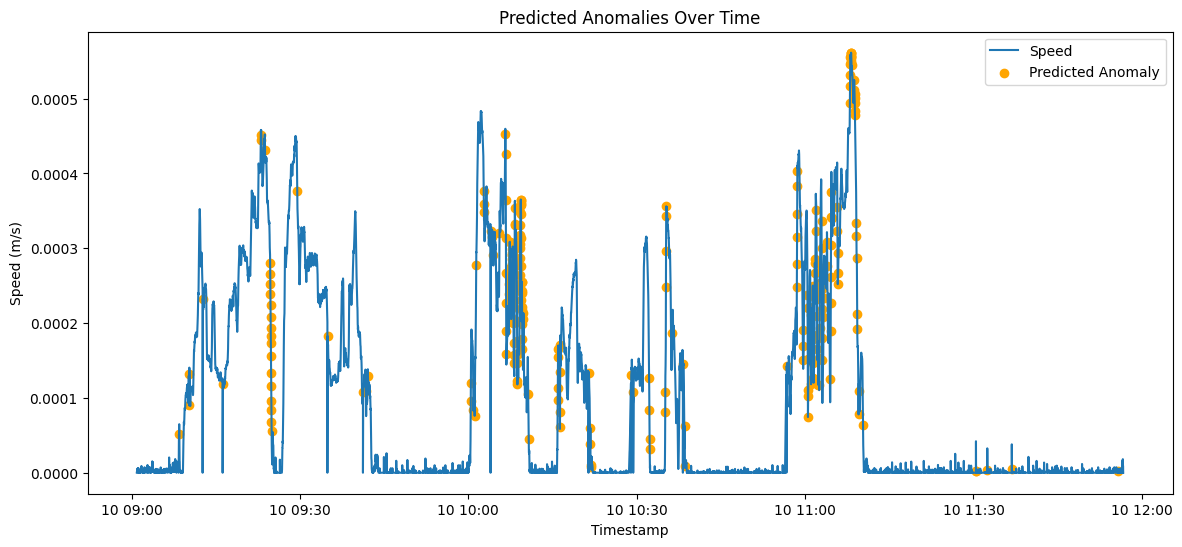

In [4]:
# Predict future anomalies
y_pred = model.predict(X)
predicted_anomalies = y_pred > 0.5  # Convert probabilities to binary predictions


# Initialize the column with NaN values first to ensure compatible dtype
data['predicted_anomaly'] = np.nan

# Use .loc for assignment and explicitly cast to float
data.loc[window_size:, 'predicted_anomaly'] = predicted_anomalies.flatten().astype(float)


# Plot predicted anomalies
plt.figure(figsize=(14, 6))
plt.plot(data['timestamp'], data['speed'], label="Speed")
plt.scatter(data['timestamp'][data['predicted_anomaly'] == 1], 
            data['speed'][data['predicted_anomaly'] == 1], color='orange', label="Predicted Anomaly")
plt.title("Predicted Anomalies Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.show()


In [5]:
plt.savefig('image.svg')

<Figure size 640x480 with 0 Axes>